In [21]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pathlib import Path
current_path = Path.cwd()


In [22]:
start = dt.datetime(2010,4,23)  ####added 60 days
end = dt.datetime(2018,12,31)
stk_data = pd.read_csv(current_path / 'Data/1Day_only_trading_time_std_60.csv',delimiter=',')
print((stk_data['Date'][2]))
stk_data['Date'] = pd.to_datetime(stk_data['Date'], format="%Y-%m-%d")
whole_data = stk_data.set_index('Date')
stk_data = whole_data[start:end]

test_start = dt.datetime(2019,1,1)
test_end = dt.datetime(2019,9,2)
test_data = whole_data[test_start: test_end]

2010-02-03


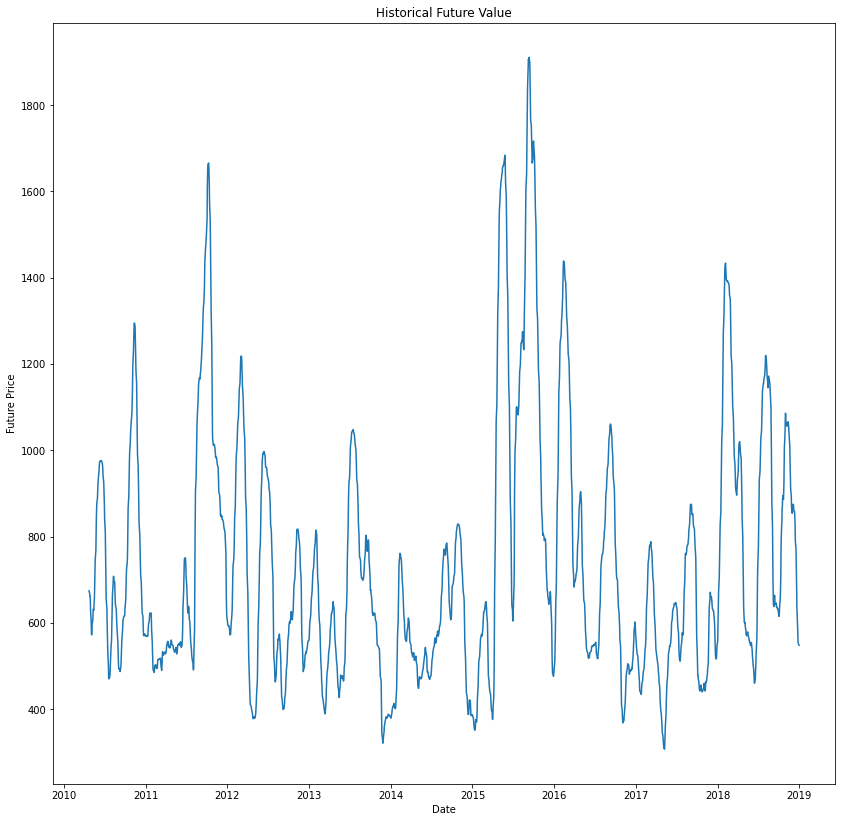

In [23]:
plt.figure(figsize=(14,14))
plt.plot(stk_data['Close'])
plt.title('Historical Future Value')
plt.xlabel('Date')
plt.ylabel('Future Price')
plt.show()

In [24]:
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']

<ipython-input-24-37fafb69b7ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stk_data['Date'] = stk_data.index


In [25]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(stk_data)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [27]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
69/69 [==============================] - 12s 76ms/step - loss: 0.0360
Epoch 2/15
69/69 [==============================] - 5s 73ms/step - loss: 0.0070
Epoch 3/15
69/69 [==============================] - 5s 79ms/step - loss: 0.0047
Epoch 4/15
69/69 [==============================] - 5s 76ms/step - loss: 0.0043
Epoch 5/15
69/69 [==============================] - 5s 71ms/step - loss: 0.0034
Epoch 6/15
69/69 [==============================] - 5s 79ms/step - loss: 0.0030
Epoch 7/15
69/69 [==============================] - 6s 86ms/step - loss: 0.0025
Epoch 8/15
15/69 [=====>........................] - ETA: 4s - loss: 0.0026

In [ ]:
testdataframe= test_data
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<ipython-input-140-56b0ab1662c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataframe['Date'] = testdataframe.index


In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

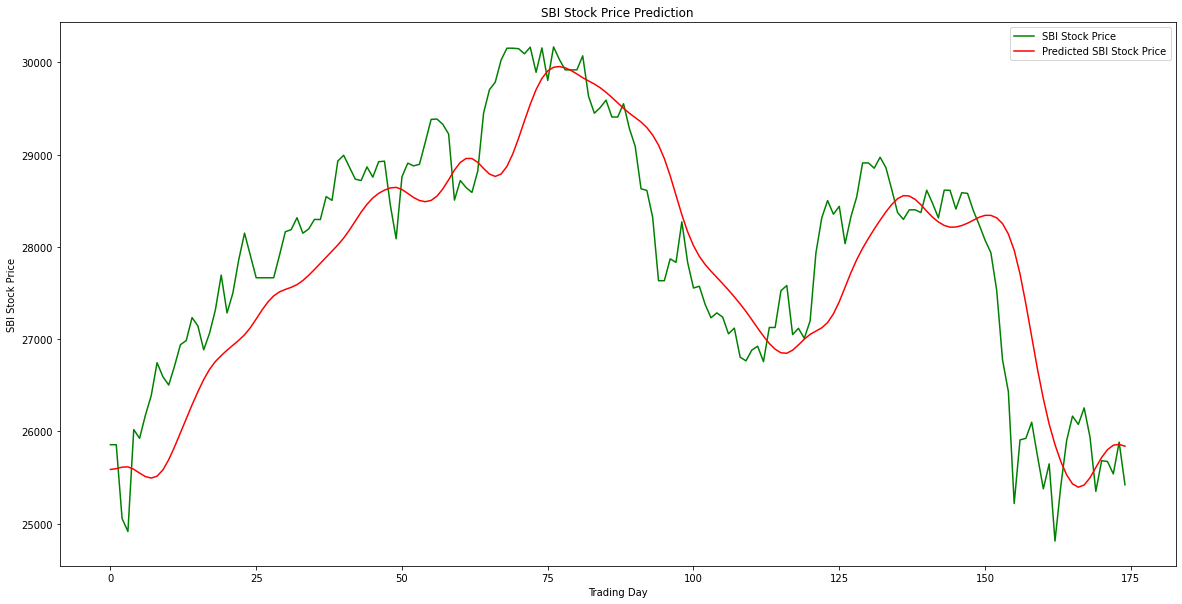

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_stock_price = regressor.predict(X_train)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

testdataframe= stk_data[60:]
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values

<ipython-input-143-bffcf1e6762b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataframe['Date'] = testdataframe.index


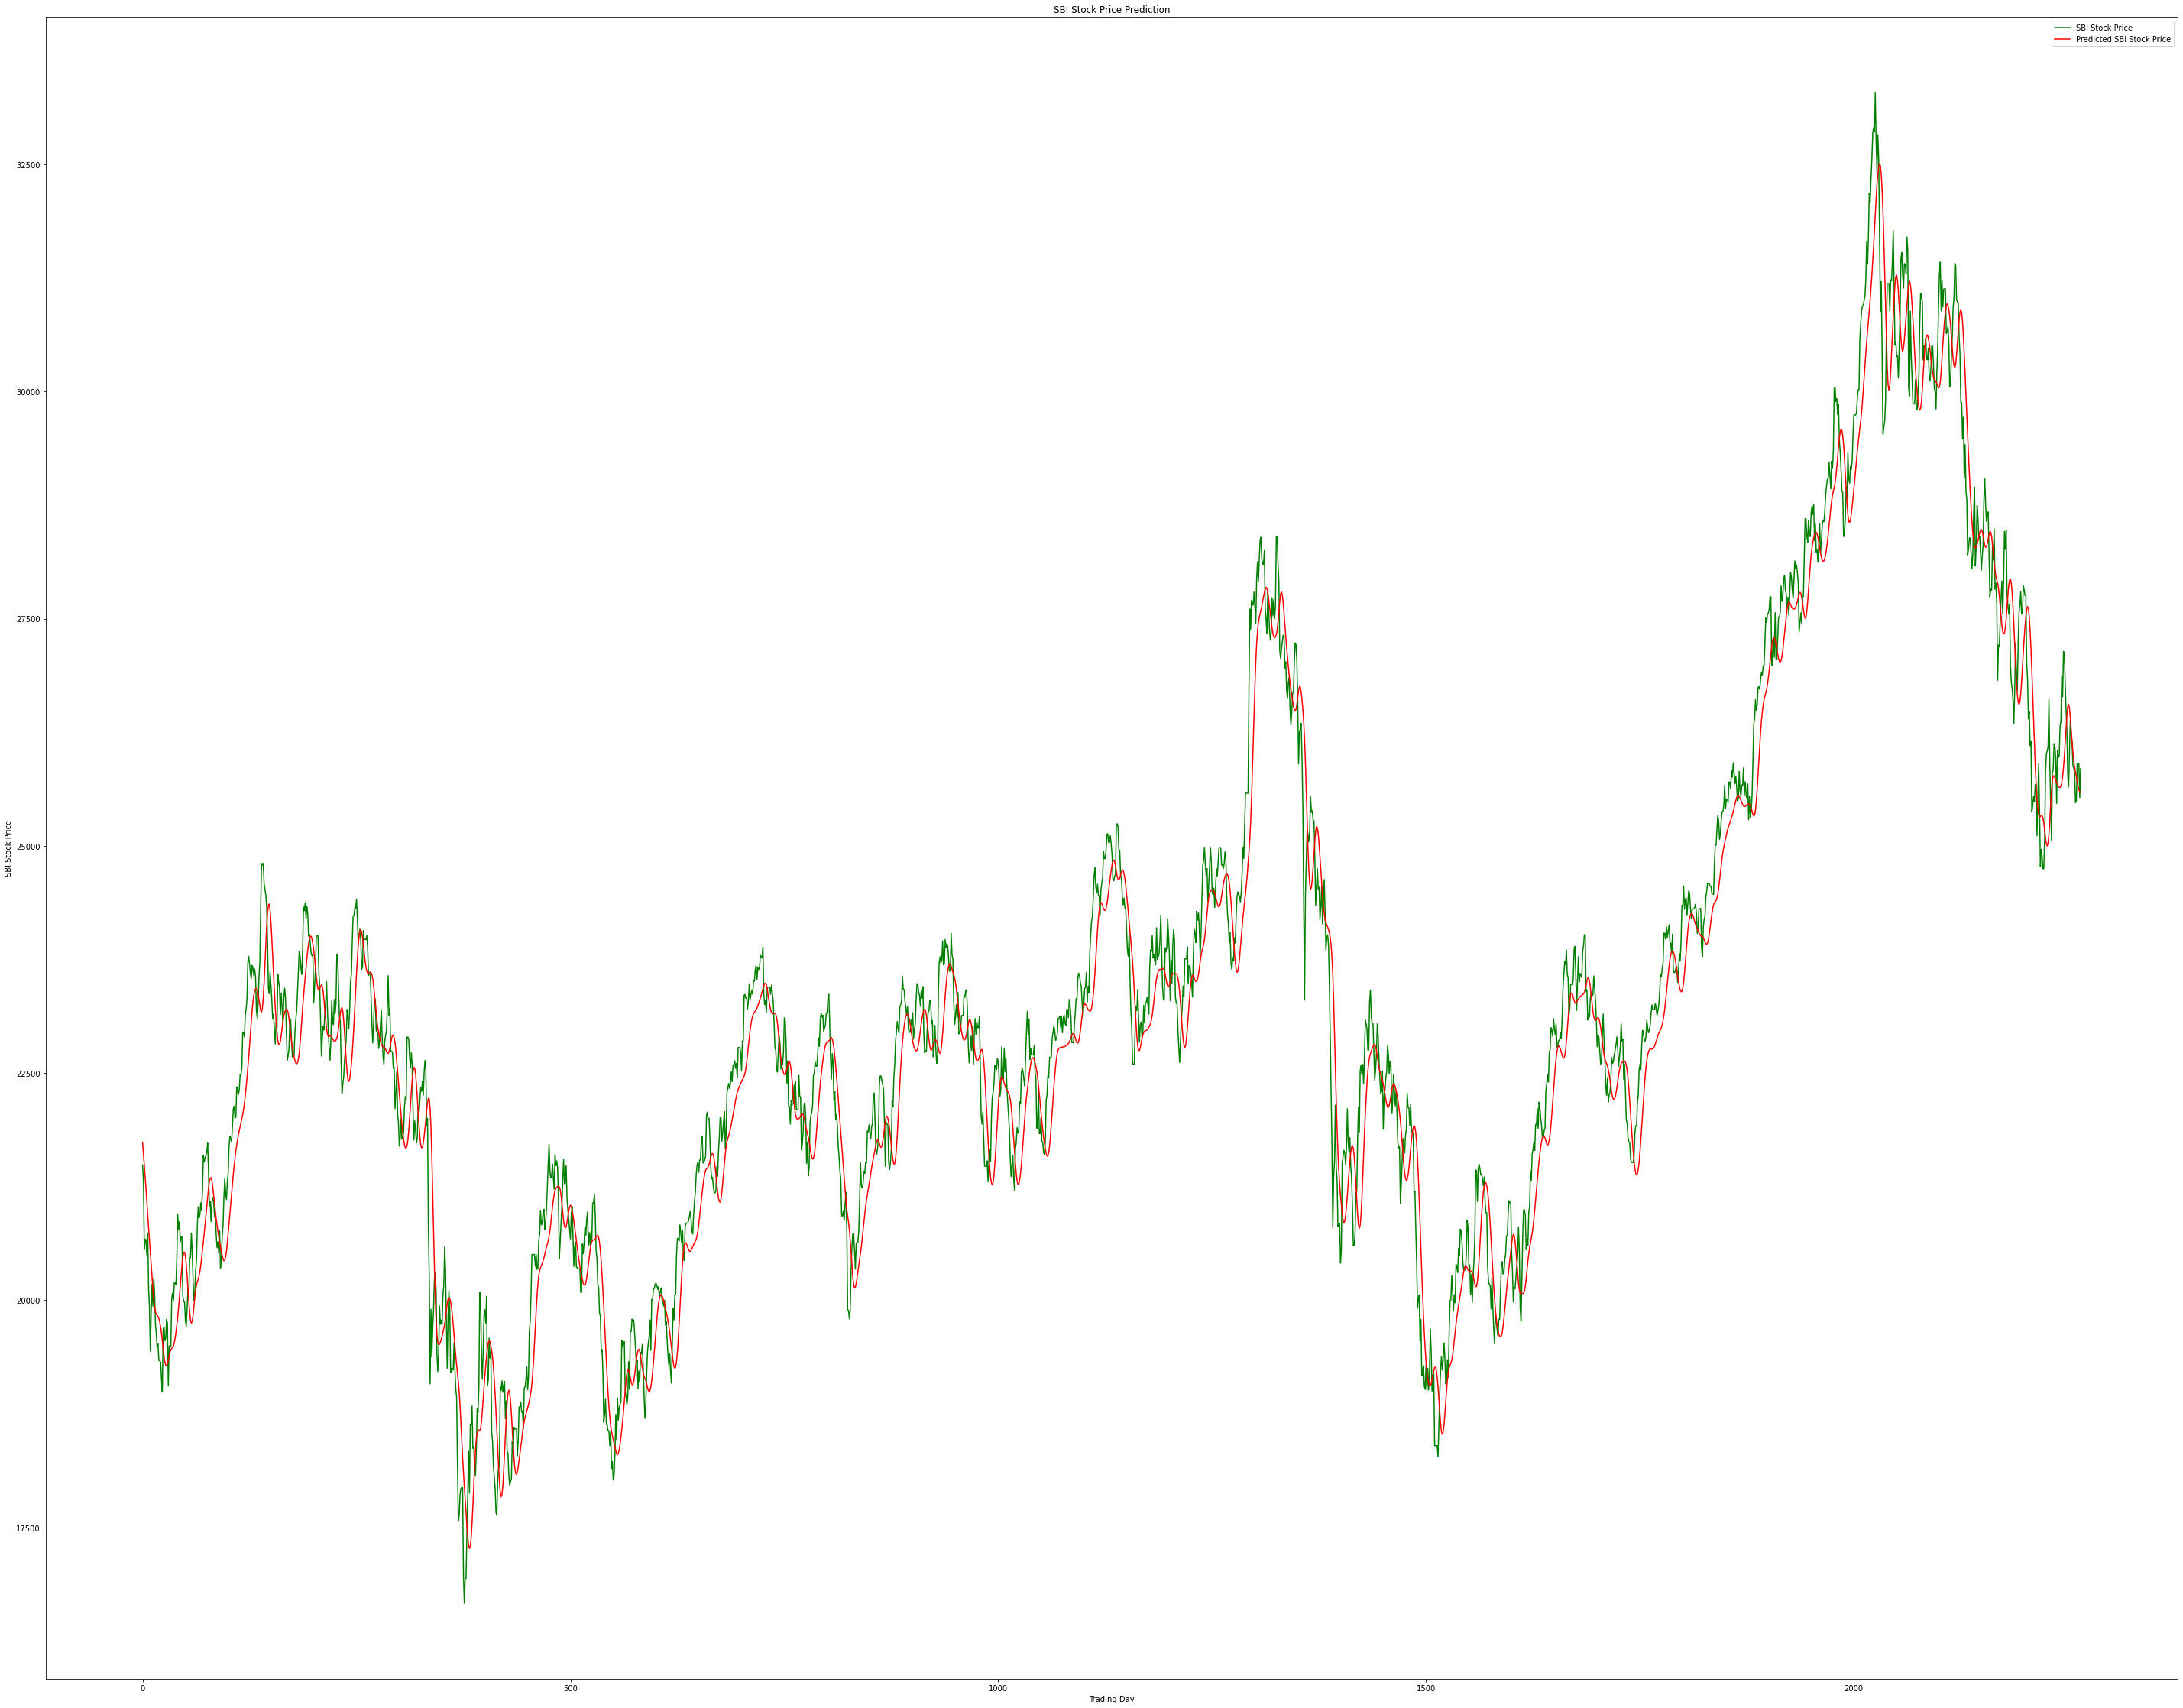

In [ ]:
plt.figure(figsize=(50,40))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()
